In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('quntity_sum_sorted_by_date_complete.csv')

In [3]:
unique_dates = df[[
    'transaction_date']].drop_duplicates().values
# Split the dates into 80:20 train and test sets
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.2, shuffle=False)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(
            input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

c:\Users\Panamgama\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([261])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Panamgama\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([261])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Panamgama\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([261])) that is different to the input size (torch.Size([1])). This will likely lead to in

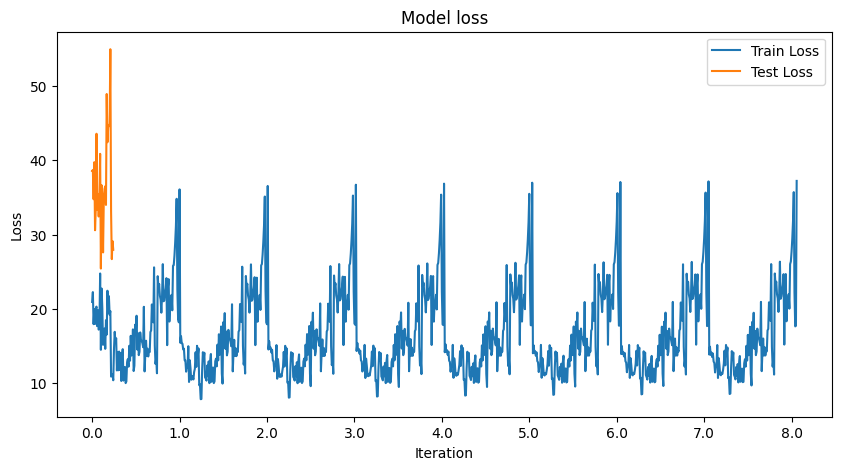

In [6]:
# Initialize the model, loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 8
train_losses = []
for i in range(epochs):
    for date in train_dates:
        # Prepare the data
        records = df[(df['transaction_date'] == date[0])
                     ][['transaction_qty', 'day_of_week']]
        data = torch.tensor(records.values.reshape(
            (records.shape[0], 1, 2)), dtype=torch.float)
        next_day_index = np.where(unique_dates == date)[0][0] + 1
        if next_day_index < len(unique_dates):
            next_day_date = unique_dates[next_day_index][0]
            next_day_record = df[(df['transaction_date']
                                  == next_day_date)]['transaction_qty']
            target = torch.tensor(next_day_record.values, dtype=torch.float)

            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            prediction = model(data)

            # Calculate the loss
            loss = loss_function(prediction, target)
            train_losses.append(loss.item())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

# Test loop
test_losses = []
for date in test_dates:
    # Prepare the data
    records = df[(df['transaction_date'] == date[0])
                 ][['transaction_qty', 'day_of_week']]
    data = torch.tensor(records.values.reshape(
        (records.shape[0], 1, 2)), dtype=torch.float)
    next_day_index = np.where(unique_dates == date)[0][0] + 1
    if next_day_index < len(unique_dates):
        next_day_date = unique_dates[next_day_index][0]
        next_day_record = df[(df['transaction_date'] ==
                              next_day_date)]['transaction_qty']
        target = torch.tensor(next_day_record.values, dtype=torch.float)

        # Forward pass
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            prediction = model(data)

        # Calculate the loss
        loss = loss_function(prediction, target)
        test_losses.append(loss.item())

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.xticks(np.arange(0, len(train_losses), step=120),
           np.arange(0, len(train_losses)/120))
plt.legend()
plt.show()